In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
from importlib import reload

import KernelTools
reload(KernelTools)
from KernelTools import *

from Kernels import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm.auto import tqdm

from jax.scipy.linalg import solve


import sympy as sym
from sympy import factorial
from sympy.series.series import series


In [2]:
jax.grad(jnp.linalg.norm)(0.)

Array(nan, dtype=float64, weak_type=True)

In [25]:
from jax import custom_jvp

@custom_jvp
def two_norm(x):
  return jnp.sqrt(jnp.sum(x**2))

@two_norm.defjvp
def two_norm_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = two_norm(x)
  ans_dot = jnp.dot(x,x_dot)/(two_norm(x)+1e-32)
  return ans, jnp.where(ans!=0,ans_dot,0.)


In [29]:
def build_matern(p,rho):
    exp_multiplier = -sym.sqrt(2 * p + 1)
    coefficients = [
        (factorial(p)/factorial(2*p)) * (factorial(p + i) / (factorial(i) * factorial(p - i)))
        * (sym.sqrt(8 * p + 4))**(p - i) 
        for i in range(p + 1)]
    powers = list(range(p,-1,-1))

    jax_coefficients = jnp.array(list(map(float,coefficients)))
    jax_powers = jnp.array(powers)
    jax_exp_multiplier = float(exp_multiplier)

    d = sym.symbols('d')
    matern = sum([c * (d**power) for c,power in zip(coefficients,powers)])*sym.exp(exp_multiplier * d)

    def matern_func(x,y):
        scaled_diff = (x-y)/rho
        d = two_norm(scaled_diff)
        matern_eval= jnp.sum(jax_coefficients*jnp.power(d,jax_powers))*jnp.exp(jax_exp_multiplier * d)
        return matern_eval#jnp.where(d2<eps, asymptotic, true)
        
    return matern_func


In [45]:
p = 2

exp_multiplier = -sym.sqrt(2 * p + 1)
coefficients = [
    (factorial(p)/factorial(2*p)) * (factorial(p + i) / (factorial(i) * factorial(p - i)))
    * (sym.sqrt(8 * p + 4))**(p - i) 
    for i in range(p + 1)]
powers = list(range(p,-1,-1))

jax_coefficients = jnp.array(list(map(float,coefficients)))
jax_powers = jnp.array(powers)
jax_exp_multiplier = float(exp_multiplier)

d = sym.symbols('d')
matern = sum([c * (d**(power/2)) for c,power in zip(coefficients,powers)])*sym.exp(exp_multiplier * sym.sqrt(d))
# S = series(sym.log(matern),d,1e-6,2*p+1).removeO()
S = series(matern,d,0,2*p+1).removeO()
# polyS = sym.Poly(S,d)
# asy_coeffs = polyS.coeffs()
# asy_coeffs = jnp.array(list(map(float,asy_coeffs)))

# asy_powers = polyS.monoms()
# half_asy_powers = jnp.array(asy_powers)[:,0]//2

In [46]:
sym.simplify(matern)

(sqrt(5)*d**0.5 + 5*d**1.0/3 + 1)*exp(-sqrt(5)*sqrt(d))

In [47]:
sym.simplify(sym.Derivative(matern,d))

(0.5*sqrt(5)/d**0.5 + 1.66666666666667)*exp(-sqrt(5)*sqrt(d)) - sqrt(5)*(sqrt(5)*d**0.5 + 5*d**1.0/3 + 1)*exp(-sqrt(5)*sqrt(d))/(2*sqrt(d))

[2 1 0]


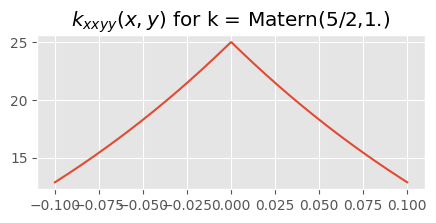

In [28]:
k = setup_matern(2)(1.)
extent = 0.1
grid = jnp.linspace(-extent,extent,500)
result = jax.vmap(diff2_k(diff2_k(k,0),1),in_axes = (None,0))(0.,grid)
plt.figure(figsize=(5,2))
plt.plot(grid,result)
plt.title("$k_{xxyy}(x,y)$ for k = Matern(5/2,1.)")
plt.show()

In [49]:
import jax
import sympy
import sympy2jax

x_sym = sympy.symbols("x_sym")
cosx = 1.0 * sympy.cos(x_sym)
sinx = 2.0 * sympy.sin(x_sym)
mod = sympy2jax.SymbolicModule([cosx, sinx])  # PyTree of input expressions

x = jax.numpy.zeros(3)
out = mod(x_sym=x)  # PyTree of results.
params = jax.tree.leaves(mod)  # 1.0 and 2.0 are parameters.


In [50]:
mod

SymbolicModule(
  nodes=[
    _Func(
      _func=<function fn_>,
      _args=[
        _Float(_value=weak_f64[]),
        _Func(_func=<wrapped function cos>, _args=[_Symbol(_name='x_sym')])
      ]
    ),
    _Func(
      _func=<function fn_>,
      _args=[
        _Float(_value=weak_f64[]),
        _Func(_func=<wrapped function sin>, _args=[_Symbol(_name='x_sym')])
      ]
    )
  ],
  has_extra_funcs=False
)